In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from sklearn.model_selection import train_test_split
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from nvae_layers import SqueezeExciteLayer
from nvae_layers import FactorizedDownsample
from nvae_layers import ResidualDecoderCell
from nvae_layers import ResidualEncoderCell
from nvae_layers import MergeCellPeak
from nvae_layers import MergeCell
from nvae_layers import NvaeConv2D
from nvae_model import  create_nvae
from nvae_model import get_last_z_output, dictate_next_output, set_model_merge_mode, linterp_zs
from dataset_utils import LfwDataset

print(f'Using Python={sys.version}')
print(f'Using Tensorflow={tf.__version__}')
print(f'Using Keras={tf.keras.__version__}')
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) == 0:
    print("No GPU(s) available")
else:
    print("GPU(s) Available: ") 
    for g in gpus:
        print('  ', g)

Using Python=3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
Using Tensorflow=2.3.0
Using Keras=2.4.0
GPU(s) Available: 
   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
IMAGE_SIZE=(64, 64, 3)
BATCH_SIZE=32
LOAD_COUNT=2000  # set to None to use full dataset

In [4]:
lfw = LfwDataset()

print('Loading a sample of the dataset to check sizes')
lfw.tfds_load(load_count=100)
orig_shape = lfw.get_base_img_shape()
#SIZE_SCALAR = - orig_shape[-3] / IMAGE_SIZE[-3]

print()
print('Loading the full dataset, resampled/rescaled')
lfw.tfds_load(scale=IMAGE_SIZE[-3], load_count=LOAD_COUNT)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64

Loading a sample of the dataset to check sizes
Train samples: 80
Val samples:   10
Test samples:  10
lfw.data_sample.shape: (10, 160, 160, 3)

Loading the full dataset, resampled/rescaled
Train samples: 1600
Val samples:   200
Test samples:  200
lfw.data_sample.shape: (32, 64, 64, 3)


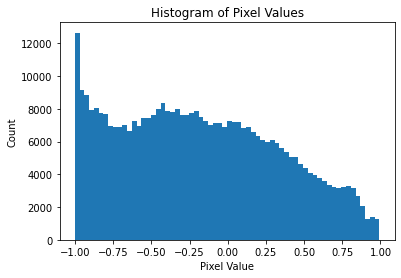

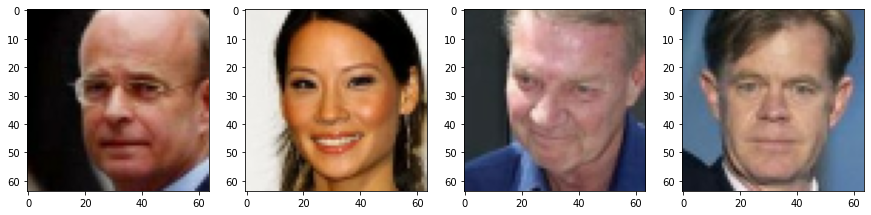

In [5]:
fig, ax = plt.subplots()
ax.hist(lfw.data_sample.reshape((-1,)), bins=64)
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Pixel Values')

fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    axs[i].imshow(lfw.unscale_img(lfw.data_sample[i]))

In [ ]:
x = inputs = L.Input(shape=IMAGE_SIZE)
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, downsample=True, scale_channels=2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, downsample=True, scale_channels=2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, upsample=True, scale_channels=-2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, upsample=True, scale_channels=-2)(x)
x = NvaeConv2D(kernel_size=1, abs_channels=3)(x)

test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()

In [8]:
print('Pass thru 8 images:', test_model(lfw.data_sample[:8]).shape)

Pass thru 8 images: (8, 96, 96, 3)


In [ ]:
x = inputs = L.Input(shape=IMAGE_SIZE)
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell(downsample=True)(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell(downsample=True)(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell(upsample=True)(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell(upsample=True)(x)
x = NvaeConv2D(kernel_size=3, abs_channels=3)(x)
test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()

In [ ]:
test_model(lfw.data_sample[:4, :16, :16, :], training=True).shape

In [ ]:
# TEST THE MODEL CONSTRUCTION
full_model = create_nvae(
    input_shape=IMAGE_SIZE,
    base_num_channels=8,
    nscales=2,
    ngroups=4,
    ncells=2,
    nlatent=8,
    num_prepost_blocks=1,
    num_prepost_cells=2,
    use_adaptive_ngroups=True)

print('Full model output shape:', full_model(lfw.data_sample[:4, :, :, :], training=False).shape)
print('Full model output shape:', full_model(lfw.data_sample[:4, :, :, :], training=True).shape)

In [39]:
full_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
pre_stem (NvaeConv2D)           (None, 64, 64, 8)    232         input_8[0][0]                    
__________________________________________________________________________________________________
pre_blk0_c0 (ResidualEncoderCel (None, 64, 64, 8)    1324        pre_stem[0][0]                   
__________________________________________________________________________________________________
pre_blk0_c1 (ResidualEncoderCel (None, 32, 32, 16)   3908        pre_blk0_c0[0][0]                
_______________________________________________________________________________________

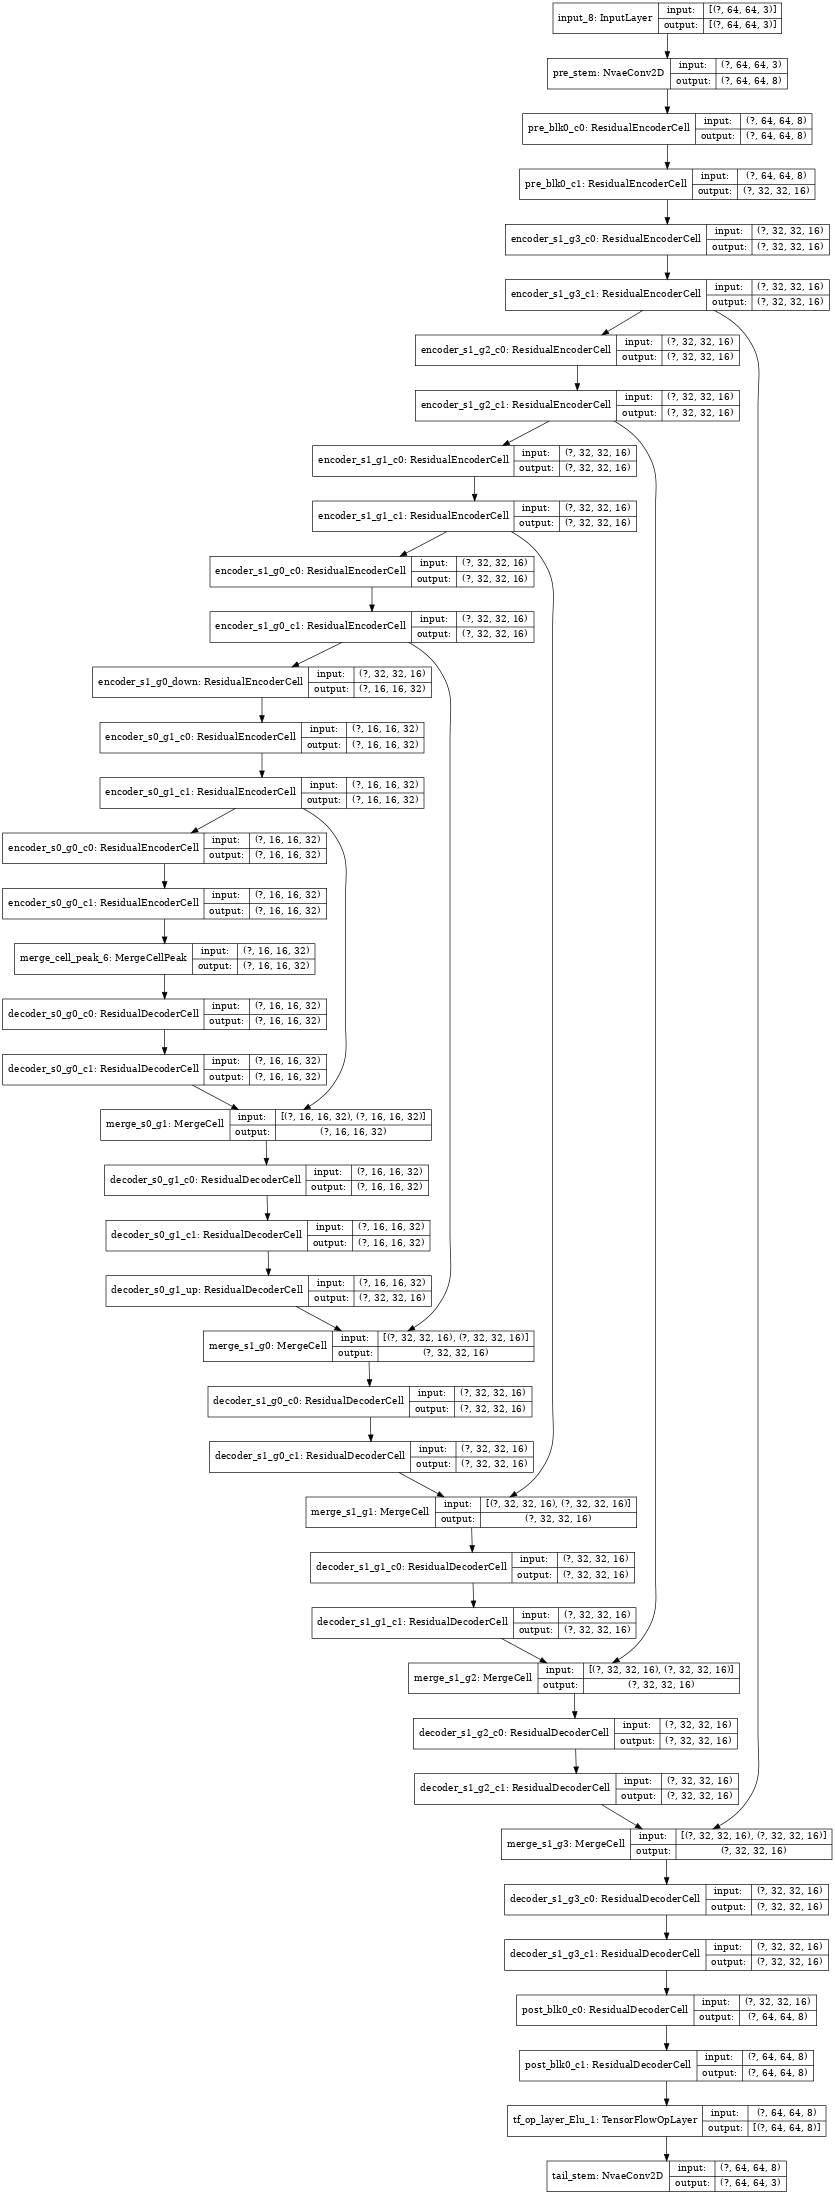

In [40]:
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True, dpi=48)
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True, dpi=48, to_file='small_nvae.png')

In [6]:
BATCH_SIZE=6
print('Loading the full dataset, resampled/rescaled')
#lfw.tfds_load(scale=SIZE_SCALAR, load_count=2000)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64
lfw.tfds_load(scale=IMAGE_SIZE[-3], load_count=None)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64
train_xx, val_xx, test_xx = lfw.get_vae_data_splits(batch_size=BATCH_SIZE)

Loading the full dataset, resampled/rescaled
Train samples: 10586
Val samples:   1324
Test samples:  1323
lfw.data_sample.shape: (32, 64, 64, 3)


In [7]:
full_model = None  # release prev model
full_nvae = None  # release prev model

tf.keras.backend.clear_session()

# CELEB 64 params ... but this is 1e9 params?!
'''
INITIAL_LR = 4e-4
full_nvae = create_nvae(
    input_shape=IMAGE_SIZE,
    base_num_channels=64,
    nscales=3,
    ngroups=20,
    ncells=2,
    nlatent=20,
    num_prepost_blocks=1,
    num_prepost_cells=2)
'''
INITIAL_LR = 6e-4
full_nvae = create_nvae(
    input_shape=IMAGE_SIZE,
    base_num_channels=32,
    nscales=4,
    ngroups=20,
    ncells=1,
    nlatent=20,
    num_prepost_blocks=1,
    num_prepost_cells=2,
    kl_center_scalar=0.001,
    kl_residual_scalar=0.01,
    use_adaptive_ngroups=True)

full_nvae.summary()

Group sizes [2, 5, 10, 20]
Enc s=3, ngrps=20
Enc s=2, ngrps=10
Enc s=1, ngrps=5
Enc s=0, ngrps=2
Dec s=0, ngrps=2
Dec s=1, ngrps=5
Dec s=2, ngrps=10
Dec s=3, ngrps=20
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
pre_stem (NvaeConv2D)           (None, 64, 64, 32)   928         input_1[0][0]                    
__________________________________________________________________________________________________
pre_blk0_c0 (ResidualEncoderCel (None, 64, 64, 32)   19108       pre_stem[0][0]                   
__________________________________________________________________________________________________
pre_blk0_c1 (Residu

In [ ]:
test_out = full_nvae(tf.zeros((BATCH_SIZE,) + IMAGE_SIZE))
opt = tf.keras.optimizers.Adamax(INITIAL_LR)
#opt = tf.keras.optimizers.Adamax()
full_nvae.compile(opt, loss='mse', metrics='mse')

cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse', factor=0.5, patience=5, verbose=1)
cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=20, restore_best_weights=True)
#cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=8)
cb_chkpoint = tf.keras.callbacks.ModelCheckpoint('best_nvae.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

hist = full_nvae.fit(
    train_xx.repeat(),
    validation_data=val_xx,
    steps_per_epoch=int(0.8*2000//BATCH_SIZE),
    epochs=80,
    #callbacks=[cb_earlystop, cb_reducelr])
    callbacks=[cb_chkpoint, cb_earlystop, cb_reducelr])

Epoch 1/80
138/266 [==============>...............] - ETA: 1:28 - loss: 0.0457 - mse: 0.0354

In [ ]:
#suffix = '4_16_1_160m_kl0.0001'
#suffix = '4_2_1_fixed_var_kl0.001'
suffix = '4_20_1_adaptive_kl0.001'

In [ ]:
full_nvae.load_weights('best_nvae.h5')

In [ ]:
plt.plot(hist.history['val_mse'])
plt.plot(hist.history['val_loss'])
plt.legend(['Validation MSE', 'Validation Total Loss'])
plt.ylim(0, 0.1)
#full_nvae.load_weights('best_vae')

In [ ]:
set_model_merge_mode(full_nvae, 'merge')
nvae_proc = full_nvae(lfw.data_sample)

fig, axs = plt.subplots(8, 4, figsize=(12, 20))
for a,i in enumerate(range(0, 16)):
    #print(lfw.data_sample[i].shape)
    #print(model_parts.encoder(tf.expand_dims(lfw.data_sample[i], axis=0)))
    orig = lfw.data_sample[i]
    vaed = nvae_proc[i]
    mrow = a//2
    mcol = a%2
    axs[mrow][mcol*2].imshow(lfw.unscale_img(orig))
    axs[mrow][mcol*2+1].imshow(lfw.unscale_img(vaed))

best_loss = min(hist.history['val_loss'])
    
fig.savefig(f'images/nvae_roundtrip_samples_{IMAGE_SIZE[-3]}.png')

In [ ]:
set_model_merge_mode(full_nvae, 'sample')

nvae_proc = full_nvae(tf.zeros_like(lfw.data_sample))
fig, axs = plt.subplots(8, 4, figsize=(12, 20))
for a,i in enumerate(range(0, 32)):
    #print(lfw.data_sample[i].shape)
    #print(model_parts.encoder(tf.expand_dims(lfw.data_sample[i], axis=0)))
    vaed = nvae_proc[i]
    mrow = a//4
    mcol = a%4
    axs[a//4][a%4].imshow(lfw.unscale_img(vaed))

best_loss = min(hist.history['val_loss'])
    
fig.savefig(f'images/nvae_gen_random.png')

In [ ]:
f1 = lfw.data_sample[0, :, :, :]
f2 = lfw.data_sample[1, :, :, :]

In [ ]:
set_model_merge_mode(full_nvae, 'merge')

f1_recon = tf.squeeze(full_nvae(tf.expand_dims(f1, axis=0)))
f1_zs = get_last_z_output(full_nvae)

f2_recon = tf.squeeze(full_nvae(tf.expand_dims(f2, axis=0)))
f2_zs = get_last_z_output(full_nvae)

f1_dictated = dictate_next_output(full_nvae, f1_zs, (64,64,3))
f2_dictated = dictate_next_output(full_nvae, f2_zs, (64,64,3))

fig,axs = plt.subplots(2, 3, figsize=(15,6))
axs[0][0].imshow(lfw.unscale_img(f1))
axs[0][1].imshow(lfw.unscale_img(f1_recon))
axs[0][2].imshow(lfw.unscale_img(f1_dictated))

axs[1][0].imshow(lfw.unscale_img(f2))
axs[1][1].imshow(lfw.unscale_img(f2_recon))
axs[1][2].imshow(lfw.unscale_img(f2_dictated))

In [ ]:

def merge_faces(model, face1, face2, num_samples=5):
    _ = tf.squeeze(model(tf.expand_dims(face1, axis=0)))
    f1_zs = get_last_z_output(model)

    _ = tf.squeeze(model(tf.expand_dims(face2, axis=0)))
    f2_zs = get_last_z_output(model)

    f12_zs = linterp_zs(f1_zs, f2_zs, alpha=0.5)
    f12_dictated = dictate_next_output(model, f12_zs, IMAGE_SIZE)

    fig,axs = plt.subplots(1, num_samples, figsize=(25,8))
    d_alpha = 1.0 / (num_samples-1)
    for i in range(num_samples):
        blended_zs = linterp_zs(f1_zs, f2_zs, alpha=1.0 - i * d_alpha)
        blended_face = dictate_next_output(model, blended_zs, (64,64,3))
        axs[i].imshow(lfw.unscale_img(blended_face))
        
    return fig,axs



In [ ]:
f1 = lfw.data_sample[0, :, :, :]
f2 = lfw.data_sample[1, :, :, :]
merge_faces(full_nvae, f1, f2)

In [ ]:
def load_img(fn, sz):
    img = PIL.Image.open(fn)
    img = img.resize((sz, sz))
    img = np.array(img) / 128.0 - 1.0
    return img

In [ ]:
mkr = load_img('external_faces/mkr5b.jpg', IMAGE_SIZE[-3])
jkr = load_img('external_faces/jkr1a.jpg', IMAGE_SIZE[-3])
merge_faces(full_nvae, mkr, jkr, num_samples=5)
                 

In [ ]:
mkr = load_img('external_faces/mkr5b.jpg', IMAGE_SIZE[-3])
jkr = load_img('external_faces/jkr3b.jpg', IMAGE_SIZE[-3])[:, ::-1, :]
fig,axs = merge_faces(full_nvae, mkr, jkr, num_samples=5)

In [ ]:
fig.savefig(f'mkr2jkr_{IMAGE_SIZE[-3]}.png')

In [ ]:
fn = f'model_{IMAGE_SIZE[-3]}_{suffix}.h5'
full_nvae.save_weights(fn)
print(fn)

In [ ]:
full_nvae.load_weights(fn)

In [ ]:
mkr = load_img('external_faces/biden3.jpg', IMAGE_SIZE[-3])
jkr = load_img('external_faces/trump2.jpg', IMAGE_SIZE[-3])
fig,axs = merge_faces(full_nvae, mkr, jkr)

In [ ]:
mkr = load_img('external_faces/affleck1.jpg', IMAGE_SIZE[-3])
jkr = load_img('external_faces/damon2.jpg', IMAGE_SIZE[-3])
fig,axs = merge_faces(full_nvae, mkr, jkr)

In [25]:
full_nvae.save(f'model_{IMAGE_SIZE[-3]}_{suffix}_MODEL.h5')

In [26]:
from nvae_model import custom_model_classes

In [ ]:
full_nvae = tf.keras.models.load_model('model_64_131m_model.h5', custom_objects=custom_model_classes)

In [ ]:
full_nvae.merge_cells = []
for l in full_nvae.layers:
    if hasattr(l, 'last_z_output'):
        full_nvae.merge_cells.append(l)
        
    
print(len(full_nvae.merge_cells))